In [1]:
import numpy as np
from scipy.stats._continuous_distns import genpareto
import matplotlib.pyplot as plt
from pathlib import Path
import netCDF4 as nc
from pathlib import Path
from datetime import datetime

In [2]:
# %%Config
thr_org = np.array([6, 20])
thr_gum = 1.25

# %%Mkdir
now = datetime.now()
dt_string = now.strftime("%Y-%m-%d-%H%M")
# dir_out = f"./output/temp/"
dir_out = f"./output/common/"
path_out = Path(dir_out)
if not path_out.exists():
    path_out.mkdir()


# %%Load STM & Exposure
fl = list(Path("./summary_data").glob("*.nc"))
num_events = len(fl)
num_vars = 2
num_nodes = nc.Dataset(fl[0]).dimensions["node"].size
stm_h = np.zeros((num_events))
stm_u = np.zeros((num_events))
stm_h_coord = np.zeros((num_events, 2))
stm_u_coord = np.zeros((num_events, 2))
is_e_h = np.full((num_events), False)
is_e_u = np.full((num_events), False)
is_me_h = np.full((num_events), False)
is_me_u = np.full((num_events), False)
exp_h = np.zeros((num_events, num_nodes))
exp_u = np.zeros((num_events, num_nodes))
latlon_ds = nc.Dataset("latlon.nc")
latlon = np.array([latlon_ds["lat"][:], latlon_ds["lon"][:]]).T
rng = np.random.default_rng()

for i, fp in enumerate(fl):
    ds = nc.Dataset(fp)
    # if i == 1:
    #     print(ds)
    stm_h[i], stm_u[i] = ds["stm_h"][:], ds["stm_u"][:]
    stm_h_coord[i, :], stm_u_coord[i, :] = ds["stm_h_coord"][:], ds["stm_u_coord"][:]
    exp_h[i, :], exp_u[i, :] = ds["exp_h"][:], ds["exp_u"][:]
    # ts[ds['scenario'][:]-1] = ds['track'][:]

stm = np.stack((stm_h, stm_u), axis=1)
exp = np.stack((exp_h, exp_u), axis=2)
var_name = ["$H_s$", "$U$"]
var_name_g = ["$\hat H_s$", "$\hat U$"]
unit = ["[m]", "[m/s]"]
pos_color = plt.rcParams["axes.prop_cycle"].by_key()["color"]

In [3]:
N = 100
N_THR = 10
thr_list_h = np.linspace(5,15,N_THR)
thr_list_u = np.linspace(10,50,N_THR)
thr_list = np.stack((thr_list_h, thr_list_u),axis=1)
genpar_params = np.zeros((N_THR, N, 3, num_vars))
num_samples = np.zeros((N_THR, N, num_vars))
for ti in range(N_THR):
    for vi in range(num_vars):
        _stm_bootstrap = rng.choice(stm[:, vi], size=(N, stm[:, vi].shape[0]))
        for i in range(N):
            _stm = _stm_bootstrap[i, :]
            _stm_pot = _stm[_stm > thr_list[ti,vi]]
            _xp, _mp, _sp = genpareto.fit(_stm_pot, floc=thr_list[ti,vi])
            genpar_params[ti, i, :, vi] = [_xp, _mp, _sp]
            num_samples[ti, i, vi] = np.count_nonzero(_stm_pot)

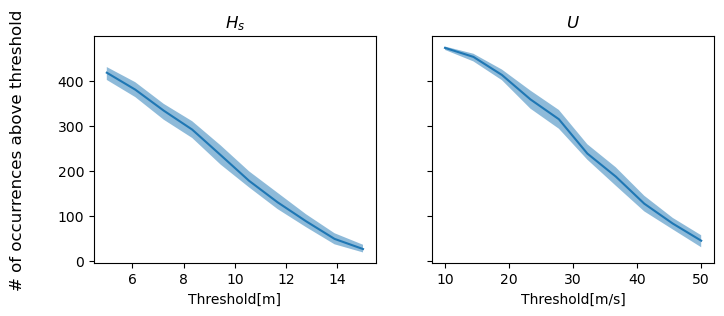

In [6]:
fig, ax = plt.subplots(1,2,sharey=True, figsize=(8,3),dpi=100,facecolor='white')
fig.supylabel("# of occurrences above threshold")

med = np.percentile(num_samples,50,axis=1)
u95 = np.percentile(num_samples,97.5,axis=1)
l95 = np.percentile(num_samples, 2.5,axis=1)
for vi in range(num_vars):
    ax[vi].plot(thr_list[:,vi], med[:,vi])
    ax[vi].fill_between(thr_list[:,vi], u95[:,vi], l95[:,vi],alpha=0.5)
    ax[vi].set_title(var_name[vi])
    # ax[vi].axhline(20,color='red')
ax[0].set_xlabel('Threshold[m]')
ax[1].set_xlabel('Threshold[m/s]')

plt.savefig(f"{dir_out}/Marginal_sample_num.png", bbox_inches="tight")

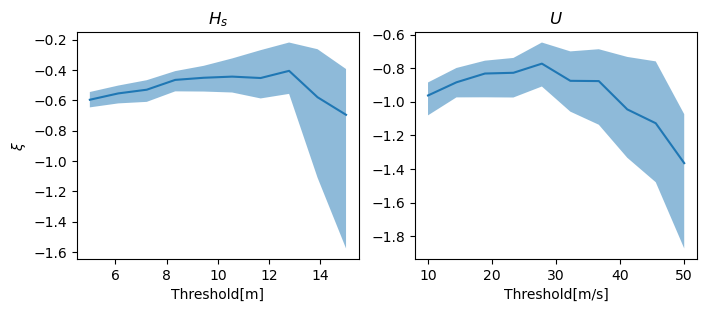

In [7]:
fig, ax = plt.subplots(1,2, figsize=(8,3),dpi=100,facecolor='white')
u95 = np.percentile(genpar_params,97.5,axis=1)
l95 = np.percentile(genpar_params, 2.5,axis=1)
med = np.percentile(genpar_params,50.0,axis=1)
var_name = ["$H_s$", "$U$"]
par_name = ["$\\xi$", "$\\mu$", "$\\sigma$"]
for vi in range(num_vars):
    ax[vi].set_title(var_name[vi])
    ax[0].set_ylabel(par_name[0])
    ax[vi].plot(thr_list[:,vi], med[:,0,vi])
    ax[vi].fill_between(thr_list[:,vi], u95[:,0,vi], l95[:,0,vi], alpha = 0.5)

ax[0].set_xlabel('Threshold[m]')
ax[1].set_xlabel('Threshold[m/s]')

plt.savefig(f"{dir_out}/Marginal_param_vs_threshold.png", bbox_inches="tight")